# Continuous RL. DDPG, TD3

In this seminar, we explore **continuous control** in reinforcement learning (RL), where the action space is continuous rather than discrete. Unlike previous sessions that focused on environments with a finite set of actions (e.g., CartPole with “left” or “right”), continuous control tasks require selecting actions from a continuous range, such as applying a specific torque or force. This introduces new challenges: policies must output real-valued vectors, exploration becomes more subtle, and Q-learning-based methods need careful adaptation due to the infinite number of possible actions. At the same time, some aspects become conceptually simpler—for instance, there is no need for action discretization or manual tuning of discrete action sets.

In this notebook, we will implement and compare two prominent actor-critic algorithms for continuous control: **Deep Deterministic Policy Gradient (DDPG)** and its improved variant, **Twin Delayed DDPG (TD3)**. We will test them in two environments: the simple PointMaze and the more complex MuJoCo HalfCheetah task.

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install matplotlib
    !pip -q install numpy
    !pip -q install wandb==0.19.8
    !pip -q install gymnasium[mujoco]
    !pip -q install imageio

In [ ]:
!wandb login

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from copy import deepcopy
from gymnasium.spaces import Box
from torch import nn

## [Prerequisite: do not modify, can skip the section] PointMaze environment

![image.png](attachment:88664138-6286-4d3f-9670-70c09107178d.png)

In [ ]:
class Maze:
    def __init__(self, *segment_dicts, goal_noise = True, goal_squares=None, start_squares=None):
        self.goal_noise = goal_noise
        self._segments = {'origin': {'loc': (0.0, 0.0), 'connect': set()}}
        self._locs = set()
        self._locs.add(self._segments['origin']['loc'])
        self._walls = set()
        for direction in ['up', 'down', 'left', 'right']:
            self._walls.add(self._wall_line(self._segments['origin']['loc'], direction))
        self._last_segment = 'origin'
        self.goal_squares = None

        if goal_squares is None:
            self._goal_squares = None
        elif isinstance(goal_squares, str):
            self._goal_squares = [goal_squares.lower()]
        elif isinstance(goal_squares, (tuple, list)):
            self._goal_squares = [gs.lower() for gs in goal_squares]
        else:
            raise TypeError

        if start_squares is None:
            self.start_squares = ['origin']
        elif isinstance(start_squares, str):
            self.start_squares = [start_squares.lower()]
        elif isinstance(start_squares, (tuple, list)):
            self.start_squares = [ss.lower() for ss in start_squares]
        else:
            raise TypeError

        for segment_dict in segment_dicts:
            self._add_segment(**segment_dict)
        self._finalize()

    def set_seed(self, seed = None):
        self.np_rng = np.random.default_rng(seed)

    @staticmethod
    def _wall_line(coord, direction):
        x, y = coord
        if direction == 'up':
            w = [(x - 0.5, x + 0.5), (y + 0.5, y + 0.5)]
        elif direction == 'right':
            w = [(x + 0.5, x + 0.5), (y + 0.5, y - 0.5)]
        elif direction == 'down':
            w = [(x - 0.5, x + 0.5), (y - 0.5, y - 0.5)]
        elif direction == 'left':
            w = [(x - 0.5, x - 0.5), (y - 0.5, y + 0.5)]
        else:
            raise ValueError
        w = tuple([tuple(sorted(line)) for line in w])
        return w

    def _add_segment(self, name, anchor, direction, connect=None, times=1):
        name = str(name).lower()
        original_name = str(name).lower()
        if times > 1:
            assert connect is None
            last_name = str(anchor).lower()
            for time in range(times):
                this_name = original_name + str(time)
                self._add_segment(name=this_name.lower(), anchor=last_name, direction=direction)
                last_name = str(this_name)
            return

        anchor = str(anchor).lower()
        assert anchor in self._segments

        direction = str(direction).lower()

        final_connect = set()

        if connect is not None:
            if isinstance(connect, str):
                connect = str(connect).lower()
                assert connect in ['up', 'down', 'left', 'right']
                final_connect.add(connect)
            elif isinstance(connect, (tuple, list)):
                for connect_direction in connect:
                    connect_direction = str(connect_direction).lower()
                    assert connect_direction in ['up', 'down', 'left', 'right']
                    final_connect.add(connect_direction)

        sx, sy = self._segments[anchor]['loc']
        dx, dy = 0.0, 0.0
        if direction == 'left':
            dx -= 1
            final_connect.add('right')
        elif direction == 'right':
            dx += 1
            final_connect.add('left')
        elif direction == 'up':
            dy += 1
            final_connect.add('down')
        elif direction == 'down':
            dy -= 1
            final_connect.add('up')
        else:
            raise ValueError

        new_loc = (sx + dx, sy + dy)
        assert new_loc not in self._locs

        self._segments[name] = {'loc': new_loc, 'connect': final_connect}
        for direction in ['up', 'down', 'left', 'right']:
            self._walls.add(self._wall_line(new_loc, direction))
        self._locs.add(new_loc)

        self._last_segment = name

    def _finalize(self):
        for segment in self._segments.values():
            for c_dir in list(segment['connect']):
                wall = self._wall_line(segment['loc'], c_dir)
                if wall in self._walls:
                    self._walls.remove(wall)

        if self._goal_squares is None:
            self.goal_squares = None
        else:
            self.goal_squares = []
            for gs in self._goal_squares:
                assert gs in self._segments
                self.goal_squares.append(gs)

    def plot(self, agent_pos = None, goal_pos = None, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.))
        for x, y in self._walls:
            ax.plot(x, y, 'k-')
        if agent_pos is not None:
            ax.plot(agent_pos[0], agent_pos[1], 'ro', markersize = 6)
        if goal_pos is not None:
            ax.plot(goal_pos[0], goal_pos[1], 'b*', markersize = 6)
        return fig

    def sample_start(self):
        min_wall_dist = 0.05

        s_square = self.start_squares[self.np_rng.integers(low=0, high=len(self.start_squares))]
        s_square_loc = self._segments[s_square]['loc']

        while True:
            shift = self.np_rng.uniform(low=-0.5, high=0.5, size=(2,))
            loc = s_square_loc + shift
            dist_checker = np.array([min_wall_dist, min_wall_dist]) * np.sign(shift)
            stopped_loc = self.move(loc, dist_checker)
            if float(np.sum(np.abs((loc + dist_checker) - stopped_loc))) == 0.0:
                break
        return loc[0], loc[1]

    def sample_goal(self, min_wall_dist=None):
        if min_wall_dist is None:
            min_wall_dist = 0.1
        else:
            min_wall_dist = min(0.4, max(0.01, min_wall_dist))

        if self.goal_squares is None:
            return (None, None)

        g_square = self.goal_squares[self.np_rng.integers(low=0, high=len(self.goal_squares))]
        g_square_loc = self._segments[g_square]['loc']
        if not self.goal_noise:
            return g_square_loc[0], g_square_loc[1]

        while True:
            shift = self.np_rng.uniform(low=-0.5, high=0.5, size=(2,))
            loc = g_square_loc + shift
            dist_checker = np.array([min_wall_dist, min_wall_dist]) * np.sign(shift)
            stopped_loc = self.move(loc, dist_checker)
            if float(np.sum(np.abs((loc + dist_checker) - stopped_loc))) == 0.0:
                break
        return loc[0], loc[1]

    def move(self, coord_start, coord_delta, depth=None):
        if depth is None:
            depth = 0
        cx, cy = coord_start
        loc_x0 = np.round(cx)
        loc_y0 = np.round(cy)
        #assert (float(loc_x0), float(loc_y0)) in self._locs
        dx, dy = coord_delta
        loc_x1 = np.round(cx + dx)
        loc_y1 = np.round(cy + dy)
        d_loc_x = int(np.abs(loc_x1 - loc_x0))
        d_loc_y = int(np.abs(loc_y1 - loc_y0))
        xs_crossed = [loc_x0 + (np.sign(dx) * (i + 0.5)) for i in range(d_loc_x)]
        ys_crossed = [loc_y0 + (np.sign(dy) * (i + 0.5)) for i in range(d_loc_y)]

        rds = []

        for x in xs_crossed:
            r = (x - cx) / dx
            loc_x = np.round(cx + (0.999 * r * dx))
            loc_y = np.round(cy + (0.999 * r * dy))
            direction = 'right' if dx > 0 else 'left'
            crossed_line = self._wall_line((loc_x, loc_y), direction)
            if crossed_line in self._walls:
                rds.append([r, direction])

        for y in ys_crossed:
            r = (y - cy) / dy
            loc_x = np.round(cx + (0.999 * r * dx))
            loc_y = np.round(cy + (0.999 * r * dy))
            direction = 'up' if dy > 0 else 'down'
            crossed_line = self._wall_line((loc_x, loc_y), direction)
            if crossed_line in self._walls:
                rds.append([r, direction])

        # The wall will only stop the agent in the direction perpendicular to the wall
        if rds:
            rds = sorted(rds)
            r, direction = rds[0]
            if depth < 3:
                new_dx = r * dx
                new_dy = r * dy
                repulsion = float(np.abs(self.np_rng.random() * 0.01))
                if direction in ['right', 'left']:
                    new_dx -= np.sign(dx) * repulsion
                    partial_coords = cx + new_dx, cy + new_dy
                    remaining_delta = (0.0, (1 - r) * dy)
                else:
                    new_dy -= np.sign(dy) * repulsion
                    partial_coords = cx + new_dx, cy + new_dy
                    remaining_delta = ((1 - r) * dx, 0.0)
                return self.move(partial_coords, remaining_delta, depth+1)
        else:
            r = 1.0

        dx *= r
        dy *= r
        return cx + dx, cy + dy



mazes_dict = dict()

segments_sane = [
    {'anchor': 'origin', 'direction': 'right', 'name': '1,0'},
     {'anchor': 'origin', 'direction': 'up', 'name': '0,1'},
     {'anchor': '1,0', 'direction': 'right', 'name': '2,0'},
     {'anchor': '0,1', 'direction': 'up', 'name': '0,2'},
     {'anchor': '0,2', 'direction': 'right', 'name': '1,2'},
     {'anchor': '2,0', 'direction': 'up', 'name': '2,1'},
     {'anchor': '1,2', 'direction': 'right', 'name': '2,2'},
     {'anchor': '1,2', 'direction': 'down', 'name': '1,1'},
]

segments_strange = [
    {'anchor': 'origin', 'direction': 'right', 'name': '1,0'},
     {'anchor': 'origin', 'direction': 'up', 'name': '0,1'},
     {'anchor': '1,0', 'direction': 'right', 'name': '2,0'},
     {'anchor': '0,1', 'direction': 'up', 'name': '0,2'},
     {'anchor': '0,2', 'direction': 'right', 'name': '1,2'},
     {'anchor': '2,0', 'direction': 'up', 'name': '2,1'},
     {'anchor': '1,2', 'direction': 'right', 'name': '2,2'},
     {'anchor': '0,2', 'direction': 'up', 'name': '0,3'},
     {'anchor': '2,1', 'direction': 'right', 'name': '3,1'},
     {'anchor': '1,2', 'direction': 'down', 'name': '1,1'},
     {'anchor': '3,1', 'direction': 'down', 'name': '3,0'},
     {'anchor': '1,2', 'direction': 'up', 'name': '1,3'},
     {'anchor': '3,1', 'direction': 'right', 'name': '4,1'},
     {'anchor': '1,3', 'direction': 'up', 'name': '1,4'},
     {'anchor': '4,1', 'direction': 'right', 'name': '5,1'},
     {'anchor': '4,1', 'direction': 'up', 'name': '4,2'},
     {'anchor': '5,1', 'direction': 'down', 'name': '5,0'},
     {'anchor': '3,0', 'direction': 'right', 'name': '4,0'},
     {'anchor': '1,4', 'direction': 'right', 'name': '2,4'},
     {'anchor': '4,2', 'direction': 'right', 'name': '5,2'},
     {'anchor': '2,4', 'direction': 'right', 'name': '3,4'},
     {'anchor': '3,4', 'direction': 'up', 'name': '3,5'},
     {'anchor': '1,4', 'direction': 'left', 'name': '0,4'},
     {'anchor': '1,4', 'direction': 'up', 'name': '1,5'},
     {'anchor': '2,2', 'direction': 'up', 'name': '2,3'},
     {'anchor': '3,1', 'direction': 'up', 'name': '3,2'},
     {'anchor': '3,2', 'direction': 'up', 'name': '3,3'},
     {'anchor': '4,2', 'direction': 'up', 'name': '4,3'},
     {'anchor': '3,4', 'direction': 'right', 'name': '4,4'},
     {'anchor': '1,5', 'direction': 'right', 'name': '2,5'},
     {'anchor': '4,4', 'direction': 'right', 'name': '5,4'},
     {'anchor': '5,4', 'direction': 'down', 'name': '5,3'},
     {'anchor': '0,4', 'direction': 'up', 'name': '0,5'},
     {'anchor': '3,5', 'direction': 'right', 'name': '4,5'},
     {'anchor': '5,4', 'direction': 'up', 'name': '5,5'}
]

segments_crazy = [
    {'anchor': 'origin', 'direction': 'right', 'name': '1,0'},
     {'anchor': 'origin', 'direction': 'up', 'name': '0,1'},
     {'anchor': '1,0', 'direction': 'right', 'name': '2,0'},
     {'anchor': '0,1', 'direction': 'up', 'name': '0,2'},
     {'anchor': '0,2', 'direction': 'right', 'name': '1,2'},
     {'anchor': '2,0', 'direction': 'up', 'name': '2,1'},
     {'anchor': '1,2', 'direction': 'right', 'name': '2,2'},
     {'anchor': '0,2', 'direction': 'up', 'name': '0,3'},
     {'anchor': '2,1', 'direction': 'right', 'name': '3,1'},
     {'anchor': '1,2', 'direction': 'down', 'name': '1,1'},
     {'anchor': '3,1', 'direction': 'down', 'name': '3,0'},
     {'anchor': '1,2', 'direction': 'up', 'name': '1,3'},
     {'anchor': '3,1', 'direction': 'right', 'name': '4,1'},
     {'anchor': '1,3', 'direction': 'up', 'name': '1,4'},
     {'anchor': '4,1', 'direction': 'right', 'name': '5,1'},
     {'anchor': '4,1', 'direction': 'up', 'name': '4,2'},
     {'anchor': '5,1', 'direction': 'down', 'name': '5,0'},
     {'anchor': '3,0', 'direction': 'right', 'name': '4,0'},
     {'anchor': '1,4', 'direction': 'right', 'name': '2,4'},
     {'anchor': '4,2', 'direction': 'right', 'name': '5,2'},
     {'anchor': '2,4', 'direction': 'right', 'name': '3,4'},
     {'anchor': '3,4', 'direction': 'up', 'name': '3,5'},
     {'anchor': '1,4', 'direction': 'left', 'name': '0,4'},
     {'anchor': '1,4', 'direction': 'up', 'name': '1,5'},
     {'anchor': '2,2', 'direction': 'up', 'name': '2,3'},
     {'anchor': '3,1', 'direction': 'up', 'name': '3,2'},
     {'anchor': '5,0', 'direction': 'right', 'name': '6,0'},
     {'anchor': '3,2', 'direction': 'up', 'name': '3,3'},
     {'anchor': '4,2', 'direction': 'up', 'name': '4,3'},
     {'anchor': '6,0', 'direction': 'up', 'name': '6,1'},
     {'anchor': '6,0', 'direction': 'right', 'name': '7,0'},
     {'anchor': '6,1', 'direction': 'right', 'name': '7,1'},
     {'anchor': '3,4', 'direction': 'right', 'name': '4,4'},
     {'anchor': '1,5', 'direction': 'right', 'name': '2,5'},
     {'anchor': '7,1', 'direction': 'up', 'name': '7,2'},
     {'anchor': '1,5', 'direction': 'up', 'name': '1,6'},
     {'anchor': '4,4', 'direction': 'right', 'name': '5,4'},
     {'anchor': '5,4', 'direction': 'down', 'name': '5,3'},
     {'anchor': '0,4', 'direction': 'up', 'name': '0,5'},
     {'anchor': '7,2', 'direction': 'left', 'name': '6,2'},
     {'anchor': '1,6', 'direction': 'left', 'name': '0,6'},
     {'anchor': '7,0', 'direction': 'right', 'name': '8,0'},
     {'anchor': '7,2', 'direction': 'right', 'name': '8,2'},
     {'anchor': '2,5', 'direction': 'up', 'name': '2,6'},
     {'anchor': '8,0', 'direction': 'up', 'name': '8,1'},
     {'anchor': '3,5', 'direction': 'up', 'name': '3,6'},
     {'anchor': '6,2', 'direction': 'up', 'name': '6,3'},
     {'anchor': '6,3', 'direction': 'right', 'name': '7,3'},
     {'anchor': '3,5', 'direction': 'right', 'name': '4,5'},
     {'anchor': '7,3', 'direction': 'up', 'name': '7,4'},
     {'anchor': '6,3', 'direction': 'up', 'name': '6,4'},
     {'anchor': '6,4', 'direction': 'up', 'name': '6,5'},
     {'anchor': '8,1', 'direction': 'right', 'name': '9,1'},
     {'anchor': '8,2', 'direction': 'right', 'name': '9,2'},
     {'anchor': '2,6', 'direction': 'up', 'name': '2,7'},
     {'anchor': '8,2', 'direction': 'up', 'name': '8,3'},
     {'anchor': '6,5', 'direction': 'left', 'name': '5,5'},
     {'anchor': '5,5', 'direction': 'up', 'name': '5,6'},
     {'anchor': '7,4', 'direction': 'right', 'name': '8,4'},
     {'anchor': '8,4', 'direction': 'right', 'name': '9,4'},
     {'anchor': '0,6', 'direction': 'up', 'name': '0,7'},
     {'anchor': '2,7', 'direction': 'up', 'name': '2,8'},
     {'anchor': '7,4', 'direction': 'up', 'name': '7,5'},
     {'anchor': '9,4', 'direction': 'down', 'name': '9,3'},
     {'anchor': '9,4', 'direction': 'up', 'name': '9,5'},
     {'anchor': '2,7', 'direction': 'left', 'name': '1,7'},
     {'anchor': '4,5', 'direction': 'up', 'name': '4,6'},
     {'anchor': '9,1', 'direction': 'down', 'name': '9,0'},
     {'anchor': '6,5', 'direction': 'up', 'name': '6,6'},
     {'anchor': '3,6', 'direction': 'up', 'name': '3,7'},
     {'anchor': '1,7', 'direction': 'up', 'name': '1,8'},
     {'anchor': '3,7', 'direction': 'right', 'name': '4,7'},
     {'anchor': '2,8', 'direction': 'up', 'name': '2,9'},
     {'anchor': '2,9', 'direction': 'left', 'name': '1,9'},
     {'anchor': '7,5', 'direction': 'up', 'name': '7,6'},
     {'anchor': '1,8', 'direction': 'left', 'name': '0,8'},
     {'anchor': '6,6', 'direction': 'up', 'name': '6,7'},
     {'anchor': '0,8', 'direction': 'up', 'name': '0,9'},
     {'anchor': '7,5', 'direction': 'right', 'name': '8,5'},
     {'anchor': '6,7', 'direction': 'left', 'name': '5,7'},
     {'anchor': '2,9', 'direction': 'right', 'name': '3,9'},
     {'anchor': '3,9', 'direction': 'right', 'name': '4,9'},
     {'anchor': '7,6', 'direction': 'right', 'name': '8,6'},
     {'anchor': '3,7', 'direction': 'up', 'name': '3,8'},
     {'anchor': '9,5', 'direction': 'up', 'name': '9,6'},
     {'anchor': '7,6', 'direction': 'up', 'name': '7,7'},
     {'anchor': '5,7', 'direction': 'up', 'name': '5,8'},
     {'anchor': '3,8', 'direction': 'right', 'name': '4,8'},
     {'anchor': '8,6', 'direction': 'up', 'name': '8,7'},
     {'anchor': '5,8', 'direction': 'right', 'name': '6,8'},
     {'anchor': '7,7', 'direction': 'up', 'name': '7,8'},
     {'anchor': '4,9', 'direction': 'right', 'name': '5,9'},
     {'anchor': '8,7', 'direction': 'right', 'name': '9,7'},
     {'anchor': '7,8', 'direction': 'right', 'name': '8,8'},
     {'anchor': '8,8', 'direction': 'up', 'name': '8,9'},
     {'anchor': '5,9', 'direction': 'right', 'name': '6,9'},
     {'anchor': '6,9', 'direction': 'right', 'name': '7,9'},
     {'anchor': '8,9', 'direction': 'right', 'name': '9,9'},
     {'anchor': '9,9', 'direction': 'down', 'name': '9,8'}
]

mazes_dict['small'] = {'segments': segments_sane, 'action_range': 0.95}
mazes_dict['medium'] = {'segments': segments_strange, 'action_range': 0.95}
mazes_dict['large'] = {'segments': segments_crazy, 'action_range': 0.95}

class PointEnv:
    def __init__(self, maze_type = None, timelimit = None):
        self.timelimit = timelimit

        self._mazes = mazes_dict
        self.maze_type = maze_type.lower()

        assert self.maze_type in self._mazes

        if self.maze_type == 'small':
            goal_square = '2,2'
        elif self.maze_type == 'medium':
            goal_square = '5,5'
        elif self.maze_type == 'large':
            goal_square = '9,9'

        self._state = dict(state=None, goal=None, timestep=None, done=None,)

        self.dist_threshold = 0.25
        self.action_range = mazes_dict[self.maze_type]['action_range']
        self.maze = Maze(*mazes_dict[self.maze_type]['segments'], goal_noise=False, goal_squares = goal_square)
        self.seed = None

    @property
    def observation_space(self):
        if self.maze_type == 'small':
            return Box(low = -0.5, high = 2.5, shape = (2,), dtype = np.float32)
        elif self.maze_type == 'medium':
            return Box(low = -0.5, high = 5.5, shape = (2,), dtype = np.float32)
        elif self.maze_type == 'large':
            return Box(low = -0.5, high = 9.5, shape = (2,), dtype = np.float32)

    @property
    def action_space(self):
        return Box(-self.action_range, self.action_range, (2, ), dtype = np.float32)

    @staticmethod
    def to_coords(x):
        if isinstance(x, (tuple, list)):
            return x[0], x[1]
        if isinstance(x, torch.Tensor):
            assert False, 'Didn\'t expect torch tensor'
        return float(x[0]), float(x[1])

    @staticmethod
    def _dist(state, goal):
        return np.sqrt(np.sum(np.power(state - goal, 2)))

    def termination_function(self, state, goal):
        state, goal = np.array(state), np.array(goal)
        close_enough = self._dist(goal, state) <= self.dist_threshold
        state_square = np.floor(state + 0.5)
        goal_square = np.floor(goal + 0.5)
        in_same_square = np.all(state_square == goal_square)
        goal_achieved = in_same_square & close_enough
        return np.array([goal_achieved])

    def reward_function(self, state, goal):
        state, goal = np.array(state), np.array(goal)
        close_enough = self._dist(goal, state) <= self.dist_threshold
        state_square = np.floor(state + 0.5)
        goal_square = np.floor(goal + 0.5)
        in_same_square = np.all(state_square == goal_square)
        goal_achieved = in_same_square & close_enough
        return np.array([goal_achieved], dtype = np.float32) - 1

    def reset(self, seed = None):
        if seed is not None:
            self.seed = seed
            self.np_rng = np.random.default_rng(seed)
            self.maze.set_seed(seed)
        s_xy = self.maze.sample_start()
        g_xy = self.maze.sample_goal(min_wall_dist=0.025 + self.dist_threshold)

        self._state = {
            'state': s_xy,
            'goal': g_xy,
            'timestep': 0,
            'terminated': False,
            'truncated': False,
        }

        return np.array(s_xy).astype(np.float32)

    def step(self, action):
        assert (self._state['terminated'] or self._state['truncated']) == False,\
            'Attempt to step in the same environment that has emitted terminated or truncated signal'
        assert np.logical_and(np.all(action < self.action_space.high + 0.001), np.all(action > self.action_space.low - 0.001)),\
        'Action must be in range specified by the environment'
        try:
            next_state = self.maze.move(
                self.to_coords(self._state['state']),
                self.to_coords(action)
            )
        except:
            print('state', self.to_coords(self._state['state']))
            print('action', self.to_coords(action))
            raise
        self._state['state'] = np.array(next_state).astype(np.float32)
        self._state['timestep'] += 1
        outp_state = {'state': self._state['state'],
                      'terminated': self.termination_function(self._state['state'], self._state['goal']),
                      'truncated': np.array([self._state['timestep'] >= self.timelimit]),
                      'reward': self.reward_function(self._state['state'], self._state['goal']),
                      'goal': self._state['goal']}
        self._state['done'] = outp_state['terminated'] or outp_state['truncated']

        return outp_state['state'], outp_state['reward'], outp_state['terminated'], outp_state['truncated'],\
            {'goal': outp_state['goal'], 'timestep': self._state['timestep'], 'timelimit': self.timelimit}

## Aux classes/funcs

In [ ]:
class RAM_ReplayBuffer:
    def __init__(self, batch_size, max_buffer_size, keys, device):
        self.memory = []
        self.batch_size = batch_size
        self.max_buffer_size = max_buffer_size
        self.keys = keys
        self.device = device

    def _add_experience(self, experience):
        self.memory.append(experience)
        if len(self.memory) > self.max_buffer_size:
            self.memory.pop(0)

    def add_trajectory(self, trajectory, env_goal = True):
        if env_goal:
            self.env_goals.append(trajectory[-1]['goal'])
        for experience in trajectory:
            self._add_experience(experience)

    def sample_batch(self, batch_size = None):
        batch_size = self.batch_size if batch_size is None else batch_size
        batch_idxs = np.random.choice(len(self.memory), size = batch_size)
        output_dict = {}

        for i in batch_idxs:
            for key in self.keys:
                if key not in output_dict.keys():
                    output_dict[key] = []
                sample = torch.from_numpy(self.memory[i][key]).to(self.device)
                output_dict[key].append(sample)

        # Convert array of dicts into dict of arrays
        return deepcopy({key: torch.stack(output_dict[key], axis=0) for key in output_dict.keys()})

In [ ]:
class ConvertedSigmoid(nn.Module):
    # Convert segment from [0; 1] to [low_bound; high_bound]
    def __init__(self, low_bound, high_bound):
        super(ConvertedSigmoid, self).__init__()
        self.low_bound = torch.tensor(low_bound)
        self.scale = torch.tensor(high_bound - low_bound)

    def forward(self, inp):
        return torch.sigmoid(inp) * self.scale.to(inp.device) + self.low_bound.to(inp.device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dims,
                 activation = nn.ReLU, output_activation = nn.Identity()):
        super(MLP, self).__init__()
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]

        input_lin = nn.Sequential(nn.Linear(input_dim, hidden_dims[0]), activation())

        if len(hidden_dims) > 1:
            intermediate_mlp = [nn.Sequential(nn.Linear(hidden_input_dim, hidden_output_dim), activation()) for \
                                hidden_input_dim, hidden_output_dim in zip(hidden_dims[:-1], hidden_dims[1:])]

        output_lin = nn.Sequential(nn.Linear(hidden_dims[-1], output_dims), output_activation)
        self.mlp = nn.Sequential(input_lin, *intermediate_mlp, output_lin)

    def forward(self, batch):
        return self.mlp(batch)

In [ ]:
def uniform(low, high):
    return np.random.rand(*[i for i in low.shape]).astype(np.float32) * (high - low) + low

# Convert environment output into experience which can be saved by replay buffer
def convert_step_output_to_experience(obs, action, reward, terminated, truncated, next_obs):
    experience = {'state': obs, 'action': action, 'reward': reward, 'terminated': terminated,
                  'truncated': truncated, 'next_state': next_obs}
    return experience

# Function for prefillment of replay buffer
def fill_buffer_with_random_agent(env, replay_buffer, preheat_steps):
    obs = env.reset()
    trajectory = []
    for preheat_steps in range(preheat_steps):
        action = uniform(low = env.action_space.low, high = env.action_space.high)
        next_obs, reward, terminated, truncated, info = env.step(action)
        experience = convert_step_output_to_experience(obs, action, reward, terminated, truncated, next_obs)
        trajectory.append(experience)

        obs = next_obs
        if terminated or truncated:
            replay_buffer.add_trajectory(trajectory, env_goal = False)
            trajectory = []
            obs = env.reset()

def render_cur_agent_position(env, agent_pos):
    if isinstance(env, PointEnv):
        # goal = env._state['goal']
        # fig = env.maze.plot(agent_pos = agent_pos, goal_pos = goal)
        # fig.canvas.draw()
        # image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        # image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        # image = np.transpose(image, axes=(2, 0, 1))
        # plt.close(fig)
        goal = env._state['goal']
        fig = env.maze.plot(agent_pos=agent_pos, goal_pos=goal)
        fig.canvas.draw()

        rgba = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        rgb = rgba[:, :, :3]  # drop alpha channel
        image = np.transpose(rgb, axes=(2, 0, 1))  # convert to (C, H, W)

        plt.close(fig)
    else:
        image = np.transpose(env.render(), axes=(2, 0, 1))
    return image

class MeanInWindowCalculator():
    def __init__(self, maxsize):
        self.memory = []
        self.maxsize = maxsize

    def put(self, item):
        self.memory.append(item)
        if len(self.memory) > self.maxsize :
            del self.memory[0]

    def calculate_mean(self):
        return np.sum(self.memory)/self.maxsize

## Train loop

In [ ]:
def train(
    name, agent, env, optim, replay_buffer, n_episodes = 5_000,
    wandb_enabled=True, log_schedule=10, val_schedule=10
):
    if wandb_enabled:
        import wandb
        wandb.init(project = 'RL_seminar_GoalRL', name=name)

    optim_steps = 0
    for episode in range(n_episodes+1):
        # Logging variables
        critic_losses, actor_losses = [], []
        train_success_rate = []

        # Train
        agent.train()
        trajectory = []
        obs = env.reset()
        terminated, truncated = False, False

        while not (terminated or truncated):
            action = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            experience = convert_step_output_to_experience(obs, action, reward, terminated, truncated, next_obs)
            trajectory.append(experience)

            batch = replay_buffer.sample_batch().copy()
            batch = {key: batch[key].to(agent.device) for key in batch.keys()}

            optim.zero_grad()
            critic_loss, actor_loss = agent.get_critic_loss(batch), 0
            critic_loss.backward()
            optim_steps += 1
            if optim_steps % UPDATE_FREQUENCY == 0:
                actor_loss += agent.get_actor_loss(batch)

                # Calculate gradient with respect to actor parameters only
                # (in loss calculation critic network is used.)
                actor_loss.backward(inputs = agent.actor_parameters())
                agent.update_target_networks()

                actor_losses.append(actor_loss.detach().cpu().numpy())
            critic_losses.append(critic_loss.detach().cpu().numpy())

            optim.step()
            obs = next_obs

        replay_buffer.add_trajectory(trajectory, env_goal = False)
        success_buffer.put(np.any([trajectory[i]['terminated'] == 1 for i in range(len(trajectory))]))
        return_buffer.put(np.sum([trajectory[i]['reward'] for i in range(len(trajectory))]))

        if episode % log_schedule == 0:
            # Logging section
            train_metrics = {
                'train/actor loss': np.mean(actor_losses),
                'train/critic loss': np.mean(critic_losses),
                'train/SR': success_buffer.calculate_mean(),
                'train/Returns': return_buffer.calculate_mean()
            }
            print(train_metrics)
            if wandb_enabled:
                wandb.log(train_metrics, step=episode)

        # Validation
        if episode % val_schedule == 0:
            agent.eval()
            is_terminated, returns = [], []
            for val_episode in range(VAL_EPISODES):
                video, terminations, rewards = [], [], []
                prev_obs, terminated, truncated = env.reset(), False, False
                while not (terminated or truncated):
                    video.append(render_cur_agent_position(env, prev_obs))
                    action = agent.act(prev_obs)
                    obs, reward, terminated, truncated, info = env.step(action)
                    terminations.append(terminated), rewards.append(reward)
                    prev_obs = obs
                terminations = np.concatenate(terminations, axis=0)
                returns.append(np.sum(rewards))
                is_terminated.append(np.max(terminations))
                episode_video = np.stack(video, axis=0)

            eval_metrics = {
                'eval/SR': np.mean(is_terminated),
                'eval/Returns': np.mean(returns),
            }
            print(eval_metrics)
            if wandb_enabled:
                eval_metrics |= {
                    'eval/example episode': wandb.Video(episode_video, fps=15)
                }
                wandb.log(eval_metrics)

    if wandb_enabled:
        wandb.finish()

# DDPG (Deep deterministic policy gradient)

Deep Deterministic Policy Gradient (DDPG) - это алгоритм, который одновременно учит Q-функцию и стратегию. Он использует off-policy данные и уравнения Беллмана для обучения Q-функции, а Q-функция используется для обучения стратегии.

Данный подход тесно связан с Q-обучением и мотивирован следующей идеей: если известна оптимальная функция action-value $Q^*(s,a)$, тогда для конкретного состояния $s_t$ оптимальное действие $a_t^*(s_t)$ может быть найдено решением:

$$a_t^*(s_t) = \arg \max_a Q^*(s_t, a).$$

Для сред с дискретным пространством действий легко найти наилучшее действие, вычислив полезность каждого из них. Для непрерывных же пространств действий вычисление полезностей для всех возможных действий невозможно, поэтому обычно поиск оптимального действия формулируют как задачу оптимизации аппроксиматором.

DDPG чередует обучение аппроксиматора полезности $Q^*(s,a)$ с обучением аппроксиматора $a^*(s)$ и делает это специальным образом именно для непрерывных (continuous) сред, что отражается в том как алгоритм вычисляет $\max_a Q^*(s,a)$.

Поскольку пространство действий непрерывно, предполагается, что функция $Q^*(s,a)$ дифференцируема по аргументу действия. Это позволяет нам установить эффективное правило обучения на основе градиента для стратегии $\mu(s)$.

NB: Краткое описание можно посмотреть здесь ([DPG](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#dpg) $\rightarrow$ [DDPG](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#ddpg)). Оригинальная статья:  [Continuous control with deep reinforcement learning (arXiv)](https://arxiv.org/abs/1509.02971).

<img src="https://spinningup.openai.com/en/latest/_images/math/5811066e89799e65be299ec407846103fcf1f746.svg">

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/DQN-DDPG.svg">

(4 балла)

In [ ]:
class DDPG(nn.Module):
    def __init__(self, obs_dim, min_action_values, max_action_values, hidden_dims,
                 exploration_std, gamma,
                 target_exponential_averaging, device):
        super(DDPG, self).__init__()
        self.device = device
        # Discount gamma
        self.gamma = gamma
        # Exponential averaging for target network updates
        self.target_exponential_averaging = target_exponential_averaging
        # Ammount of exploration noise, added to actions
        self.exploration_std = exploration_std
        # Action range in environment
        action_dim = min_action_values.shape
        self.min_action_values = torch.tensor(min_action_values).to(self.device)
        self.max_action_values = torch.tensor(max_action_values).to(self.device)

        assert len(obs_dim) == 1, 'Obs dim must be flat'
        assert len(action_dim) == 1, 'Action dim must be flat'
        # Initialise critic and target_critic as same networks
        self.critic, self._target_critic = [MLP(obs_dim[0] + action_dim[0], hidden_dims, 1).to(device) for i in range(2)]
        self.actor, self._target_actor = [
            MLP(
                obs_dim[0], hidden_dims, action_dim[0],
                output_activation=ConvertedSigmoid(min_action_values, max_action_values)
            ).to(device)
            for i in range(2)
        ]

        # Copy weights from current networks to target ones
        self._target_critic.load_state_dict(self.critic.state_dict())
        self._target_actor.load_state_dict(self.actor.state_dict())

    def _apply_exploration_noise(self, action):
        # Add noise to action. Mean must be zero, whilst std is specified as
        # self.exploration_std parameter. Don't forget to clip action to satisfy
        # environment constraints.
        # Returns modified action, saved as clipped_noisy_action
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return clipped_noisy_action

    def _split_batch_into_cur_and_next(self, batch):
        cur_sa = {'state': batch['state'], 'action': batch['action']}

        # Batch does not contatain information about next executed action.
        # Moreover, for Bellman optimality equation we need optimal action
        # not next one, which may be exploratory
        next_sa = {'state': batch['next_state'], 'action': None}
        return cur_sa, next_sa

    def _fetch_actor_input(self, batch):
        actor_input = batch['state']
        return actor_input

    def _fetch_critic_input(self, batch):
        state, action = batch['state'], batch['action']
        critic_input = torch.cat([state, action], dim=-1)
        return critic_input

    def act(self, obs):
        obs = torch.from_numpy(obs).to(self.device)
        with torch.no_grad():
            # If nn.Module in .eval() mode, then training is False
            # else if nn.Module in .train() mode, then training is True
            if self.training:
                return self._apply_exploration_noise(self.actor(obs)).cpu().numpy()

            return self.actor(obs).cpu().numpy()

    def get_critic_loss(self, batch):
        reward, terminated = batch['reward'], batch['terminated']
        cur_data, next_data = self._split_batch_into_cur_and_next(batch)
        next_actor_input = self._fetch_actor_input(next_data)

        # Calculate next action with target actor. We don't use our
        # agent actor for stability (same as target critic). Save calculated action
        # as next_action. Don't forget to turn off gradient as we use target actor
        # output as way to calculate target value
        # next_action = ...
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        next_data['action'] = next_action

        cur_critic_input, next_critic_input = self._fetch_critic_input(cur_data), self._fetch_critic_input(next_data)
        target = self._calculate_target(next_critic_input, reward, terminated)
        critic_loss = torch.mean((self.critic(cur_critic_input) - target)**2, dim = 0)
        return critic_loss

    def get_actor_loss(self, batch):
        cur_data, _ = self._split_batch_into_cur_and_next(batch)
        actor_inp = self._fetch_actor_input(cur_data)
        action = self.actor(actor_inp)

        # Pass action formed by actor for calculation of critic value
        # Afterwards, we will calculate gradient based on critic output
        # with respect to actor parameters (See train cycle)
        cur_data['action'] = action
        cur_critic_input = self._fetch_critic_input(cur_data)

        # Actor loss enforces action generation which will maximize critic output
        # actor_loss = ...
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return actor_loss

    def _calculate_target(self, target_input, reward, terminated):
        terminated = terminated.int()
        # Calculate target value. Don't forget to turn off gradient for target!
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return target

    def update_target_networks(self):
        for target_net, net in zip([self._target_critic, self._target_actor],
                                   [self.critic, self.actor]):
            for param_name, param in target_net.state_dict().items():
                param.data.copy_(param.data * self.target_exponential_averaging +
                                 net.state_dict()[param_name].data * (1-self.target_exponential_averaging))

    def critic_parameters(self):
        return list(self.critic.parameters())

    def actor_parameters(self):
        return list(self.actor.parameters())

    def parameters(self):
        return self.critic_parameters() + self.actor_parameters()

## DDPG Hyperparameters

In [ ]:
# ENVIRONMENT PARAMETERS
EPISODE_LENGTH = 50
SEED = 42

# VALIDATION PARAMETERS
VAL_EPISODES = 10
WINDOW_SIZE = 20

# REPLAY BUFFER PARAMETERS
BATCH_SIZE = 512
MAX_BUFFER_SIZE = 1_000_000

# TD3/DDPG PARAMETERS; EXPERIENCE GATHERING
PREHEAT_STEPS = 1_000
EXPLORATION_STD = 0.15

# TD3 PARAMETERS; TRAINING AND ARCHITECTURE
HIDDEN_DIMS = [256, 256, 256]
GAMMA = 0.98
TARGET_EXPONENTIAL_AVERAGING = 0.995
LR = 3e-04
UPDATE_FREQUENCY = 2
CONFIG_CUDA = True

DEVICE = torch.device(
    'cuda:0' if torch.cuda.is_available() and CONFIG_CUDA else "cpu"
)

np.random.seed(SEED)
torch.manual_seed(SEED)

## Define variables

In [ ]:
%%time

success_buffer = MeanInWindowCalculator(WINDOW_SIZE)
return_buffer = MeanInWindowCalculator(WINDOW_SIZE)

difficulty_level = 'small'
env = PointEnv(maze_type = difficulty_level, timelimit = EPISODE_LENGTH)
env.reset(seed = SEED)

agent = DDPG(obs_dim = env.observation_space.shape,
            min_action_values = env.action_space.low, max_action_values = env.action_space.high,
            hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
            gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
            device = DEVICE)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

replay_buffer = RAM_ReplayBuffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, device=DEVICE,
                                 keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward'])

# Prefill buffer with transitions
fill_buffer_with_random_agent(env, replay_buffer, preheat_steps = PREHEAT_STEPS)

train('DDPG', agent, env, optim, replay_buffer, n_episodes=150)

## TD3

(quoted from [lil'log](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#td3))

The Q-learning algorithm is commonly known to suffer from the overestimation of the value function. This overestimation can propagate through the training iterations and negatively affect the policy. This property directly motivated Double Q-learning and Double DQN: the action selection and Q-value update are decoupled by using two value networks.

Twin Delayed Deep Deterministic (short for TD3; [Fujimoto et al., 2018](https://arxiv.org/abs/1802.09477)) applied a couple of tricks on DDPG to prevent the overestimation of the value function:

1. **Clipped Double Q-learning**: In Double Q-Learning, the action selection and Q-value estimation are made by two networks separately. In the DDPG setting, given two deterministic actors with two corresponding critics.
   However, due to the slow changing policy, these two networks could be too similar to make independent decisions. The Clipped Double Q-learning instead uses the minimum estimation among two so as to favor underestimation bias which is hard to propagate through training. However, due to the slow changing policy, these two networks could be too similar to make independent decisions. The Clipped Double Q-learning instead uses the minimum estimation among two so as to favor underestimation bias which is hard to propagate through training (see link).


2. **Delayed update of Target and Policy Networks**: In the actor-critic model, policy and value updates are deeply coupled: Value estimates diverge through overestimation when the policy is poor, and the policy will become poor if the value estimate itself is inaccurate.

   To reduce the variance, TD3 updates the policy at a lower frequency than the Q-function. The policy network stays the same until the value error is small enough after several updates. The idea is similar to how the periodically-updated target network stay as a stable objective in DQN.

3. **Target Policy Smoothing**: Given a concern with deterministic policies that they can overfit to narrow peaks in the value function, TD3 introduced a smoothing regularization strategy on the value function: adding a small amount of clipped random noises to the selected action and averaging over mini-batches.

   This approach mimics the idea of SARSA update and enforces that similar actions should have similar values.

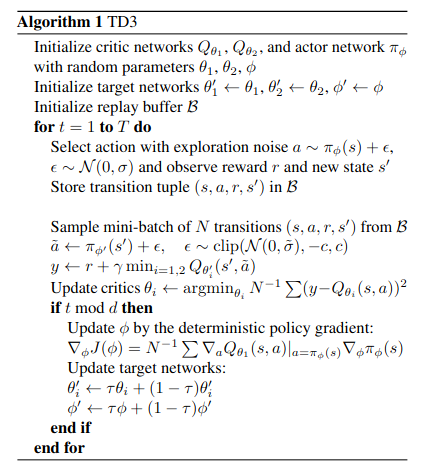

(6 баллов)

In [ ]:
SMOOTHING_STD = 0.2
SMOOTHING_CLIP = 0.5

In [ ]:
class TD3(nn.Module):
    def __init__(self, obs_dim, min_action_values, max_action_values, hidden_dims,
                 exploration_std, smoothing_std, smoothing_clip, gamma,
                 target_exponential_averaging, device):
        super(TD3, self).__init__()
        self.device = device
        # Discount gamma
        self.gamma = gamma
        # Exponential averaging for target network updates
        self.target_exponential_averaging = target_exponential_averaging
        # Ammount of exploration noise, added to actions
        self.exploration_std = exploration_std
        # Ammount of smoothing std, added to calculate critic values
        self.smoothing_std = smoothing_std
        # Clipping in case sampled noise is big enough
        self.smoothing_clip = smoothing_clip
        # Action range in environment
        action_dim = min_action_values.shape
        self.min_action_values = torch.tensor(min_action_values).to(self.device)
        self.max_action_values = torch.tensor(max_action_values).to(self.device)

        assert len(obs_dim) == 1, 'Obs dim must be flat'
        assert len(action_dim) == 1, 'Action dim must be flat'
        # Initialise critic and target_critic as same networks
        self.critic1, self._target_critic1 = [MLP(obs_dim[0] + action_dim[0], hidden_dims, 1).to(device) for i in range(2)]
        self.critic2, self._target_critic2 = [MLP(obs_dim[0] + action_dim[0], hidden_dims, 1).to(device) for i in range(2)]
        self.actor, self._target_actor = [MLP(obs_dim[0], hidden_dims, action_dim[0],
                         output_activation=ConvertedSigmoid(min_action_values, max_action_values)).to(device) for i in range(2)]

        # Copy weights from current networks to target ones
        self._target_critic1.load_state_dict(self.critic1.state_dict())
        self._target_critic2.load_state_dict(self.critic2.state_dict())
        self._target_actor.load_state_dict(self.actor.state_dict())

    def _apply_exploration_noise(self, action):
        # Same logic as introduced in DDPG
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return clipped_noisy_action

    def _apply_smoothing_noise(self, action):
        # For stability with respect to target_critic input generate smoothing noise (smoothing_std param, normal noise)
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        # Then, clip generated noise with smoothing_clip, in order to remove big deviations
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        # After, add noise to action. Don't forget to clip action in order to save action
        # in environments action range
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return clipped_smoothed_action

    def _split_batch_into_cur_and_next(self, batch):
        cur_sa = {'state': batch['state'], 'action': batch['action']}

        # Batch does not contatain information about next executed action.
        # Moreover, for Bellman optimality equation we need optimal action
        # not next one, which may be exploratory
        next_sa = {'state': batch['next_state'], 'action': None}
        return cur_sa, next_sa

    def _fetch_actor_input(self, batch):
        actor_input = batch['state']
        return actor_input

    def _fetch_critic_input(self, batch):
        state, action = batch['state'], batch['action']
        critic_input = torch.cat([state, action], dim=-1)
        return critic_input

    def act(self, obs):
        obs = torch.from_numpy(obs).to(self.device)
        with torch.no_grad():
            # If nn.Module in .eval() mode, then training is False
            # else if nn.Module in .train() mode, then training is True
            if self.training:
                return self._apply_exploration_noise(self.actor(obs)).cpu().numpy()
            return self.actor(obs).cpu().numpy()

    def get_critic_loss(self, batch):
        reward, terminated = batch['reward'], batch['terminated']
        cur_data, next_data = self._split_batch_into_cur_and_next(batch)
        next_actor_input = self._fetch_actor_input(next_data)
        with torch.no_grad():
            next_action = self._apply_smoothing_noise(self._target_actor(next_actor_input))
        next_data['action'] = next_action

        cur_critic_input, next_critic_input = self._fetch_critic_input(cur_data), self._fetch_critic_input(next_data)
        target = self._calculate_target(next_critic_input, reward, terminated)
        critic_loss1 = torch.mean((self.critic1(cur_critic_input) - target)**2, dim = 0)
        critic_loss2 = torch.mean((self.critic2(cur_critic_input) - target)**2, dim = 0)
        return (critic_loss1 + critic_loss2)/2

    def get_actor_loss(self, batch):
        cur_data, _ = self._split_batch_into_cur_and_next(batch)
        actor_inp = self._fetch_actor_input(cur_data)
        action = self.actor(actor_inp)

        # Pass action formed by actor for calculation of critic value
        # Afterwards, we will calculate gradient based on critic output
        # with respect to actor parameters (See train cycle)
        cur_data['action'] = action
        cur_critic_input = self._fetch_critic_input(cur_data)
        # As in previous terms, task of actor - maximization of critic output
        # (Now we use critic values instead of target critic ones).
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return actor_loss

    def _calculate_target(self, target_input, reward, terminated):
        terminated = terminated.int()
        # Calculate two targets, with target_critic1, target_critic2. Calculate
        # minimum from both targets. Don't forget to turn off gradient calculation!
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return target

    def update_target_networks(self):
        for target_net, net in zip([self._target_critic1, self._target_critic2, self._target_actor],
                                   [self.critic1, self.critic2, self.actor]):
            for param_name, param in target_net.state_dict().items():
                param.data.copy_(param.data * self.target_exponential_averaging +
                                 net.state_dict()[param_name].data * (1 - self.target_exponential_averaging))

    def critic_parameters(self):
        return list(self.critic1.parameters()) + list(self.critic2.parameters())

    def actor_parameters(self):
        return list(self.actor.parameters())

    def parameters(self):
        return self.critic_parameters() + self.actor_parameters()

In [ ]:
success_buffer = MeanInWindowCalculator(WINDOW_SIZE)
return_buffer = MeanInWindowCalculator(WINDOW_SIZE)

difficulty_level = 'small'
env = PointEnv(maze_type = difficulty_level, timelimit = EPISODE_LENGTH)
env.reset(seed = SEED)

agent = TD3(obs_dim = env.observation_space.shape,
            min_action_values = env.action_space.low, max_action_values = env.action_space.high,
            hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
            smoothing_std = SMOOTHING_STD, smoothing_clip = SMOOTHING_CLIP,
            gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
            device = DEVICE)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

replay_buffer = RAM_ReplayBuffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, device=DEVICE,
                                 keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward'])

# Prefill buffer with transitions
fill_buffer_with_random_agent(env, replay_buffer, preheat_steps = PREHEAT_STEPS)

train('TD3', agent, env, optim, replay_buffer, n_episodes=150)

# MuJoCo

In [ ]:
import gymnasium as gym

In [ ]:
from gymnasium import Wrapper
import numpy as np

class MuJoCoWrapper(Wrapper):
    def __init__(self, env, timelimit = 1000):
        super().__init__(env)
        self.cur_step = 0
        self.max_steps = timelimit

    def step(self, action):
        self.cur_step += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        if self.max_steps <= self.cur_step:
            truncated = True
        reward, terminated, truncated = np.array([reward], dtype=np.float32), np.array([terminated]),\
            np.array([truncated])
        obs = obs.astype(np.float32)
        return obs, reward, terminated, truncated, info

    def reset(self, seed = None, options = None):
        obs, _ = self.env.reset()
        self.cur_step = 0
        return obs.astype(np.float32)

In [ ]:
PREHEAT_STEPS = 25_000
EXPLORATION_STD = 0.1
GAMMA = 0.99

In [ ]:
import os
%env MUJOCO_GL=egl

In [ ]:
success_buffer = MeanInWindowCalculator(WINDOW_SIZE)
return_buffer = MeanInWindowCalculator(WINDOW_SIZE)

env = gym.make('HalfCheetah-v4', render_mode = 'rgb_array')
env = MuJoCoWrapper(env, timelimit = 1000)
env.reset(seed = SEED)

agent = DDPG(obs_dim = env.observation_space.shape,
            min_action_values = env.action_space.low, max_action_values = env.action_space.high,
            hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
            gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
            device = DEVICE)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

replay_buffer = RAM_ReplayBuffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, device=DEVICE,
                                 keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward'])

# Prefill buffer with transitions
fill_buffer_with_random_agent(env, replay_buffer, preheat_steps = PREHEAT_STEPS)

train('DDPG_MuJoCo', agent, env, optim, replay_buffer, n_episodes=40)

In [ ]:
success_buffer = MeanInWindowCalculator(WINDOW_SIZE)
return_buffer = MeanInWindowCalculator(WINDOW_SIZE)

env = gym.make('HalfCheetah-v4', render_mode = 'rgb_array')
env = MuJoCoWrapper(env, timelimit = 1_000)
env.reset(seed = SEED)

agent = TD3(obs_dim = env.observation_space.shape,
            min_action_values = env.action_space.low, max_action_values = env.action_space.high,
            hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
            smoothing_std = SMOOTHING_STD, smoothing_clip = SMOOTHING_CLIP,
            gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
            device = DEVICE)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

replay_buffer = RAM_ReplayBuffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, device=DEVICE,
                                 keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward'])

# Prefill buffer with transitions
fill_buffer_with_random_agent(env, replay_buffer, preheat_steps = PREHEAT_STEPS)

train('TD3_MuJoCo', agent, env, optim, replay_buffer, n_episodes=40)